In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Wczytywanie i inspekcja danych danych

In [2]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')

### Wybrane cechy

#### Ilościowe:
* w6_q21c_year - w którym roku po raz pierwszy zamieszkali ze sobą
* year_fraction_met - rok poznania z uwzględnieniem miesiąca jako ułamka

### Jakościowe:
* hcm2017q24_btwn_I_neighbor - czy są sąsiadami
* w6_otherdate_all - czy w zeszłym roku poznał(a) kogoś poza partnerem

In [3]:
cat_features = ['hcm2017q24_btwn_I_neighbor', 'w6_otherdate_all']
cont_features = ['w6_q21c_year', 'year_fraction_met']
label = 'S1'

## Transformowanie danych

Podstawowe transformowanie danych:
* zamiana wektora y na wektor 0/1 (0 - małżeństwo, 1 - brak małżeństwa)
* zamiana cech kategorycznych na one hot encoding
* usunięcie niedozwolonych przez XGBooost znaków z nazw cech

Sprawdzamy też, czy po usunięciu NaN nie zostało za mało danych.

In [4]:
data = data[cat_features+cont_features+[label]].dropna()
print("Data left: " + str(len(data)))
X = data[cat_features+cont_features].copy()
y = data[label].cat.codes

Data left: 2566


In [5]:
# Convert continuous features to numerics
for cont_feature in cont_features:
    X[cont_feature] = pd.to_numeric(X[cont_feature])
# One hot encoding
X = pd.get_dummies(X)
# Delete unwanted characters
for character in ['[', ']', '<']:
    X.columns = X.columns.str.replace(character, '')

## Trening

Do treningu używam klasyfikatora XGB z domyślnymi parametrami.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [8]:
print("Accuracy: "+str(accuracy_score(model.predict(X_test), y_test)))

Accuracy: 0.7959501557632399


/home/wojtek/Pulpit/IML/env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Zmiana w średniej odpowiedzi modelu

In [9]:
def get_averages(model, X, features_order, obs):
    averages = []
    averages.append(model.predict_proba(X)[:, 1].mean())
    
    column_names = X.columns.values
    
    for feature_name in features_order:
        names_with_prefix = [column_name for column_name in column_names if column_name.startswith(feature_name)]
        for name_with_prefix in names_with_prefix:
            X[name_with_prefix] = obs[name_with_prefix]
        averages.append(model.predict_proba(X)[:, 1].mean())
    
    return averages

In [10]:
def draw_diagram(model, X, features_order, obs):
    averages = get_averages(model, X, features_order, obs)
    print("Średnie po ustaleniu kolejnych zmiennych: " + str(averages))
    plot_data = pd.DataFrame(data = averages, index = ['średnia odp.'] + features_order)[0]
    bottom = plot_data.shift(1).fillna(0)
    plot_data = plot_data-plot_data.shift(1).fillna(0)
    colors = ['r' if x < 0 else 'g' for x in plot_data]
    colors[0] = 'b' # blue for avg. response
    plot = plot_data.plot(kind='bar', stacked = True, bottom = bottom,
                          legend = None, title = "Zmiana w średniej odpowiedzi modelu", color = colors)
    plot.plot()

In [11]:
print("Wyjaśniam obserwację: ")
print(X.loc[1][['w6_q21c_year', 'year_fraction_met']])

Wyjaśniam obserwację: 
w6_q21c_year         1996.000
year_fraction_met    1983.375
Name: 1, dtype: float64


Średnie po ustaleniu kolejnych zmiennych: [0.23974124, 0.23929207, 0.13857351, 0.13857351, 0.12466764]


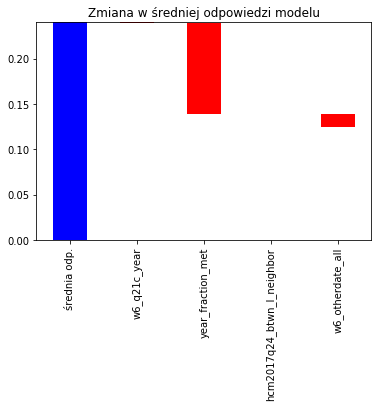

In [12]:
draw_diagram(model, X.copy(), ['w6_q21c_year', 'year_fraction_met', 'hcm2017q24_btwn_I_neighbor', 'w6_otherdate_all'], X.loc[1])

Średnie po ustaleniu kolejnych zmiennych: [0.23974124, 0.20360099, 0.13857351, 0.13857351, 0.12466764]


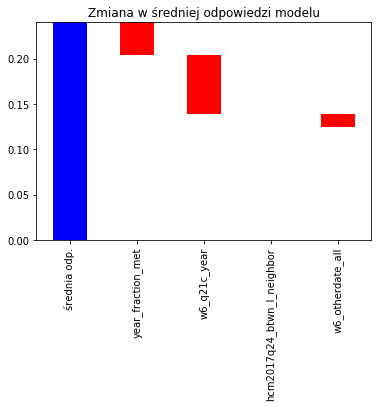

In [13]:
draw_diagram(model, X.copy(), ['year_fraction_met', 'w6_q21c_year', 'hcm2017q24_btwn_I_neighbor', 'w6_otherdate_all'], X.loc[1])

### Opis

W obu wyjaśnieniach zmienna oznaczająca rok pierwszego zamieszkania ze sobą ma duży wpływ na wynik.

W pierwszym wyjaśnieniu zmienna oznaczająca rok poznania ma duży ujemny wpływ na wynik, a w drugim wpływ ten jest praktycznie zerowy. Oznacza to, że  rok poznania (1983) ma znaczenie dopiero jeśli znamy rok pierwszego zamieszkania ze sobą (1996).

Praktycznie zerowy wpływ zmiennej 'hcm2017q24_btwn_I_neighbor' wynika najprawdopodobniej z tego, że tylko dla 2 obserwacji jest ona niezerowa.

In [14]:
X.hcm2017q24_btwn_I_neighbor_yes.sum()

2

## LIME

Będę wyjaśniał zmienne ciągłe (w6_q21c_year, year_fraction_met) tej samej obserwacji co poprzednio. <br />
Na raz będę zaburzał tylko jedną ze zmiennych, wybierając losowo którąś inną wartość ze zbioru danych. <br />
Jako odległość przyjmuję zwykłą odległość euklidesową. <br />
Jako wyjaśnialnego modelu użyję drzew decyzyjnych o głębokości 2.

In [15]:
print("Wyjaśniam obserwację: ")
print(X.loc[1][['w6_q21c_year', 'year_fraction_met']])

Wyjaśniam obserwację: 
w6_q21c_year         1996.000
year_fraction_met    1983.375
Name: 1, dtype: float64


In [47]:
from random import randint

def generate_data(observation, data, generated_size = 2000):
    examples = pd.DataFrame(columns = observation.columns.to_list())
    distances = []
    
    for i in range(generated_size):
        new_example = observation.iloc[0].copy()
        feature_name = cont_features[randint(0, len(cont_features)-1)]
        new_example[feature_name] = data.sample(n = 1)[feature_name]
        distances.append(float(abs(new_example[feature_name]-observation[feature_name])))
        examples = examples.append(new_example)
    
    return examples, distances

In [51]:
lime_data, distances = generate_data(X.loc[[1]], X)
lime_predictions = model.predict_proba(lime_data)[:, 0]

In [52]:
from sklearn import tree
dcr = tree.DecisionTreeRegressor(max_depth = 2)
dcr = dcr.fit(lime_data, lime_predictions)

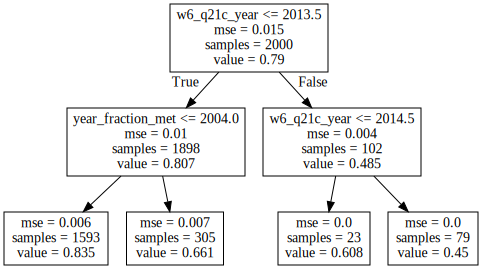

In [53]:
# Kod ze strony sklearn
import graphviz
dot_data = tree.export_graphviz(dcr,
                                feature_names = lime_data.columns.to_list(),
                                out_file=None) 
graph = graphviz.Source(dot_data)
graph.render("marriage") 
graph

### Opis

Wyjaśniana obserwacja "wpada" do najbardziej lewego liścia z prawdopodobieństwem małżeństwa równym 0.835. Zgodnie z wyjaśnieniem zwiększenie roku poznania powyżej 2004 obniżyłoby prawdopodobieństwo małżeństwa do 0.661. Podobnie zwiększenie roku zamieszkania powyżej 2013 obniżyłoby to prawdopodobieństwo.

Wyjaśnienia różnią się od przedstawionych powyżej, tam wpływ obu wyróżnionych cech był negatywny. Może to wynikać ze zbyt małej ekspresywności drzew decyzyjnych o zadanej głębokości (większość przypadków wpada do pierwszego liścia).

Dla pełności spróbujmy zastąpić drzewo decyzyjne regresją liniową:

[]

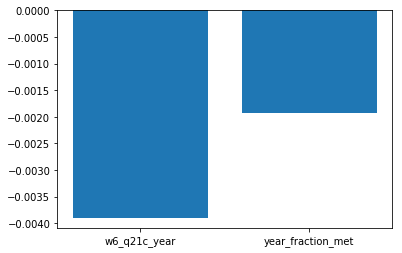

In [60]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(lime_data, lime_predictions)
plt.bar(X.columns[:2], lin_reg.coef_[:2])
plt.plot()

Tutaj, podobnie jak w wyjaśnieniu korzystającym ze średniej odpowiedzi modelu, wpływ obu cech jest ujemny.